# Visualise Clusters


## 1. Setup

```bash
conda update -n base -c defaults conda
conda install -c conda-forge hdbscan
```

In [1]:
!lscpu

Architecture:        x86_64
CPU op-mode(s):      32-bit, 64-bit
Byte Order:          Little Endian
CPU(s):              2
On-line CPU(s) list: 0,1
Thread(s) per core:  2
Core(s) per socket:  1
Socket(s):           1
NUMA node(s):        1
Vendor ID:           GenuineIntel
CPU family:          6
Model:               79
Model name:          Intel(R) Xeon(R) CPU @ 2.20GHz
Stepping:            0
CPU MHz:             2200.150
BogoMIPS:            4400.30
Hypervisor vendor:   KVM
Virtualization type: full
L1d cache:           32K
L1i cache:           32K
L2 cache:            256K
L3 cache:            56320K
NUMA node0 CPU(s):   0,1
Flags:               fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_sin

In [2]:
!git clone https://github.com/boringPpl/presidential_debates_comments_clustering.git
%cd presidential_debates_comments_clustering
!pip install -q hdbscan umap-learn langdetect

Cloning into 'presidential_debates_comments_clustering'...
remote: Enumerating objects: 246, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 246 (delta 0), reused 1 (delta 0), pack-reused 243
Receiving objects: 100% (246/246), 138.62 MiB | 27.68 MiB/s, done.
Resolving deltas: 100% (115/115), done.
Checking out files: 100% (39/39), done.
/content/presidential_debates_comments_clustering
     |████████████████████████████████| 6.4 MB 36.3 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 80 kB 8.7 MB/s 
     |████████████████████████████████| 1.1 MB 38.9 MB/s 


In [3]:
import hdbscan
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [4]:
# !head -1 cluster_data/vecs1_5k.tsv
# vecs1 = pd.read_csv("cluster_data/vecs1_5k.tsv", sep='\t', header=None)
# vecs2 = pd.read_csv("cluster_data/vecs2_5k.tsv", sep='\t', header=None)
vecs1 = pd.read_parquet("cluster_data/vecs1.parquet")
vecs2 = pd.read_parquet("cluster_data/vecs2.parquet")
print(f"Shape of vecs1: {vecs1.shape}")
print(f"Shape of vecs2: {vecs2.shape}")

Shape of vecs1: (50889, 50)
Shape of vecs2: (47164, 50)


In [5]:
# meta_lab1 = pd.read_csv("cluster_data/meta_lab1_5k.tsv", sep='\t')
# meta_lab2 = pd.read_csv("cluster_data/meta_lab2_5k.tsv", sep='\t')
meta_lab1 = pd.read_parquet("cluster_data/meta_lab1.parquet")
meta_lab2 = pd.read_parquet("cluster_data/meta_lab2.parquet")
print(f"Shape of meta_lab1: {meta_lab1.shape}")
print(f"Shape of meta_lab2: {meta_lab2.shape}")

Shape of meta_lab1: (50889, 2)
Shape of meta_lab2: (47164, 2)


In [6]:
vecs1.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49
0,1.313688,-0.512513,-0.207732,0.043059,0.157144,-0.375306,0.419370,-0.285234,-0.085951,0.136850,-0.098335,-0.000991,0.127950,0.134702,0.338932,-0.341461,-0.299435,0.208215,-0.113206,0.168908,0.131415,0.028014,-0.112246,0.222907,0.161734,0.098160,-0.013518,0.296534,-0.215466,0.007966,0.202129,-0.203425,-0.305630,-0.519923,0.261199,-0.266853,-0.042500,0.421814,0.390997,-0.083525,0.413859,-0.119872,-0.035986,-0.187366,0.111067,-0.029850,-0.149186,0.168646,-0.049566,-0.063726
1,0.689358,0.226475,-0.964849,1.136580,-0.311536,0.662296,-0.419280,-0.014195,0.002419,-0.393420,-0.043127,-0.401190,0.207515,0.862480,-0.201009,-0.058001,0.366041,-0.309371,0.686922,-0.155445,-0.020472,0.299558,-0.137516,-0.127560,0.046674,0.014269,-0.247427,0.170317,0.175874,-0.070140,-0.068942,-0.150361,0.020233,-0.132149,-0.036769,0.105407,0.049117,-0.093280,0.028974,-0.167305,-0.107784,0.039604,0.024750,-0.047668,0.109440,-0.310336,0.077474,-0.154084,0.096569,0.065059
2,1.597490,0.089166,0.158143,0.071241,0.318027,0.404058,0.023588,0.147652,-0.017239,0.486367,-0.010543,0.068922,-0.099604,-0.215154,-0.211547,0.058958,-0.085510,-0.258873,-0.049515,-0.082999,-0.192637,-0.172104,0.075122,0.322938,0.098297,0.305362,0.219523,-0.238528,0.136858,0.150440,-0.213113,0.009891,-0.119561,-0.220116,-0.052719,-0.336930,-0.442419,0.208521,0.002196,-0.313699,-0.221949,-0.087546,-0.286674,-0.107892,0.043592,0.044139,-0.129486,0.015257,-0.280108,-0.182496
3,1.439098,-0.305368,-0.253538,0.036085,0.105374,-0.035406,-0.008216,-0.078290,-0.088265,0.113093,-0.170980,0.115174,-0.075911,0.202013,0.404639,-0.312287,-0.052738,0.321047,-0.274521,-0.058644,0.018355,-0.604123,-0.087026,0.211519,0.039096,0.106786,-0.000992,-0.087410,-0.169438,-0.075487,0.251129,0.126799,-0.300119,0.138469,-0.047558,-0.187252,-0.206379,0.280177,-0.077791,-0.068197,0.276622,-0.034653,0.004380,-0.044147,0.164642,0.044199,-0.222844,-0.301126,0.037728,-0.096336
4,-0.361371,-0.696536,0.096873,0.283011,0.067292,0.156770,-0.311127,-0.004818,-0.544130,-0.422213,0.055704,0.391052,-0.077278,-0.162208,-0.111688,-0.201578,-0.177140,0.084618,0.055756,-0.118217,0.029305,0.062861,-0.309313,0.032878,-0.207900,0.193961,0.020496,-0.123940,-0.068509,-0.143110,-0.017810,0.433144,-0.037051,0.567275,-0.065362,-0.263600,0.101670,-0.244255,0.064045,-0.024622,-0.098489,0.263168,0.214644,-0.361542,-0.197097,0.084475,0.126738,-0.197691,0.254852,0.342572


In [7]:
meta_lab1.head()

,comment_text,hdb_labels
0,Trump's America: *7M cases* Biden: 200K people...,-1
1,Wow Joes laugh makes me cringe 😬,104
2,"Dang hate to say it, Trump seems sharp compar...",-1
3,"HEY BIDEN, I HAVE A FEELING YOU WERE IN ON THE...",-1
4,FAKE BRIDEN!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!...,-1


## 2. Create Clusters

In [8]:
clusterer = hdbscan.HDBSCAN()  # (min_cluster_size=5, gen_min_span_tree=True)

The following takes about 1.5 minutes

In [9]:
%time clusterer.fit(vecs1)

CPU times: user 46.6 s, sys: 373 ms, total: 47 s
Wall time: 3min 18s


HDBSCAN(algorithm='best', allow_single_cluster=False, alpha=1.0,
        approx_min_span_tree=True, cluster_selection_epsilon=0.0,
        cluster_selection_method='eom', core_dist_n_jobs=4,
        gen_min_span_tree=False, leaf_size=40,
        match_reference_implementation=False, memory=Memory(location=None),
        metric='euclidean', min_cluster_size=5, min_samples=None, p=None,
        prediction_data=False)

In [10]:
df0 = pd.concat((
    pd.DataFrame({
        'labels': clusterer.labels_,
        'probs': clusterer.probabilities_,
        'text': meta_lab1['comment_text']
    }),
    pd.DataFrame(vecs1)
), axis=1)

## 3. Trim Points to n-Color Palette

In [11]:
palette = sns.color_palette()
n = len(palette)  # There are only about 10 colors in the palette

In [12]:
df = df0.loc[(df0.labels > 0) & (df0.labels < n), :].copy()
df_vecs = df.iloc[:, 3:].T.values

In [13]:
cluster_colors = [sns.desaturate(palette[col], sat)
                  if col >= 0 else (0.5, 0.5, 0.5) for col, sat in
                  zip(df.labels.values, df.probs.values)]

## 4. Visualize Cluster

### 4.1 Principal Component Analysis

In [14]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(df_vecs)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

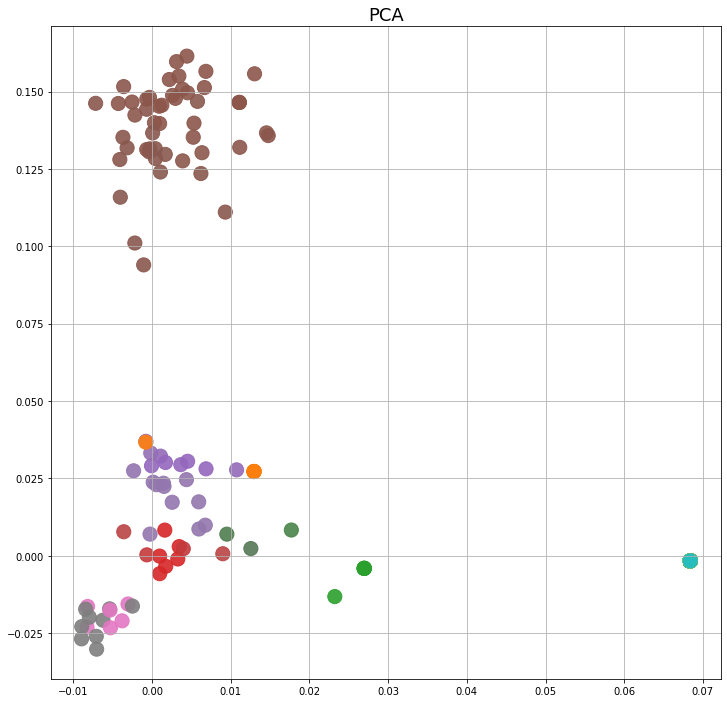

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.scatter(pca.components_[0], pca.components_[1], c=cluster_colors, s=200, alpha=0.9)
ax.grid(True)
ax.set_title("PCA", fontsize=18);

### 4.2 TSNE

In [16]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
clustertsne = tsne.fit_transform(df_vecs.T)
assert clustertsne.shape[0]==len(cluster_colors)

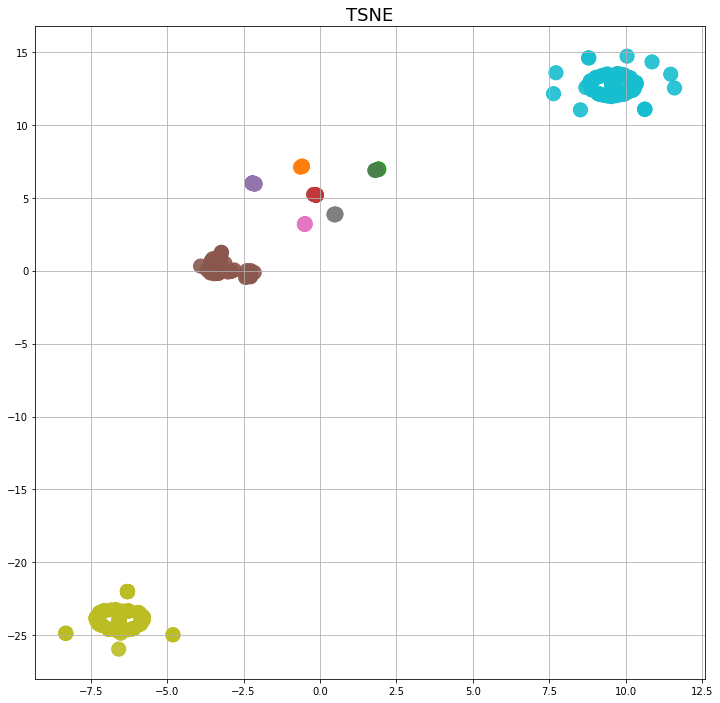

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.scatter(clustertsne[:, 0], clustertsne[:, 1], c=cluster_colors, s=200, alpha=0.9)
ax.grid(True)
ax.set_title("TSNE", fontsize=18);

In [18]:
df_tsne = pd.DataFrame({
    'x': clustertsne[:, 0],
    'y': clustertsne[:, 1],
    'label': df.labels,
    'text': df.text
})

Let's look at the labels with the highest counts.

In [19]:
df_tsne.label.value_counts()

8    107
9    105
5     50
4     20
3     10
7      9
2      9
6      6
1      6
Name: label, dtype: int64

In [20]:
df_tsne.head()

,x,y,label,text
121,-6.264042,-23.334736,8,တစ်ချို့လူ သိတယ် တာမဟုတ်ဘူးတစ်ခုခုမှားနေပြီးဆိ...
122,-6.569947,-23.959827,8,ငါတူလေ နှစ်ယောက်ရှိသေးတယ်ထိုင်းနိုင်ငံ မှာအလုပ...
123,-6.837447,-23.261541,8,‌သူ့ဟာသူကွဲနေတယ် ငါ့ပစပ် သွားပေါ့တစ်ချက် ထီ့ဖါ...
124,-6.392322,-23.337734,8,ယ်ုမဲ့ထီးဖါ ယ်ုဟှယ်ထိုင်လိုင်လေ့ဘောင်ကောကါဟော့...
125,-6.263980,-23.334740,8,အရင်ကတည်းက ငါအိမ်ထဲ့သိမ့်မနေဘူးလေ ငါဘန်ကောက်တက...


In [21]:
df_tsne[df_tsne.label==9].head()

,x,y,label,text
126,9.531810,11.939287,9,ဖုန်းတိုင်းဘယ်ရှိတော့တယ်အင်ဂလစ့်လာကြည့်မလာငါ့အ...
127,9.925249,12.112559,9,မိုက်ကော် ခက်လောက်ဟိုက်ဖျံ ခေါင်ကျင်ငိုက် ခေါ...
128,9.554129,12.733151,9,အိုခေ နာမ်အင်ဂလစ်ဂျီပီအက် နက်နော်စီ ချိက်မိုင်...
860,8.792235,14.593354,9,:)
2217,8.828059,12.857558,9,︱︱︱︱︱︱︱ ︱︱︱︱︱︱︱︱︱︱ ︱︱︱︱︱︱︱︱︱︱ ┏━┓︱...


In [22]:
df_tsne[df_tsne.label==5].head()

,x,y,label,text
256,-3.340248,0.006870,5,Chris is such an a**
652,-3.527003,-0.106053,5,Chris is absolutely the worst. Total ass
4838,-3.409585,-0.178462,5,Chris was annoying
4940,-3.331342,0.822281,5,"Poor Chris, I hope he got the day off afterwards."
7366,-3.312381,-0.157416,5,This Chris dude sucks.


In [23]:
df_tsne[df_tsne.label==4].head()

,x,y,label,text
2277,-2.203869,6.003811,4,Who is the impostor?
13038,-2.122696,5.945017,4,"ok guys i saw the imposter vent and kill, all ..."
14529,-2.124532,5.960961,4,When there are three people left in a game of ...
16471,-2.214288,6.001727,4,Who's the imposter guys? Everyone in emergency:
16666,-2.195219,5.987104,4,Can you guys just hurry up and tell us who's t...


In [24]:
df_tsne[df_tsne.label==3].head()

,x,y,label,text
11426,-0.122207,5.190212,3,"Never argue with stupid people, they will drag..."
13114,-0.125639,5.194528,3,"Never argue with idiots, he will bring you dow..."
13704,-0.184554,5.230821,3,Don't be arrogant if you argue with an arrogan...
20024,-0.116502,5.181726,3,""" don't argue with stupid people, they will be..."
27918,-0.123897,5.188694,3,"Never argue with an idiot, They will bring you..."


In [25]:
for lbl in [5, 4, 3]:
    df_tsne[df_tsne.label==lbl].to_excel(f'tsne{lbl}.xlsx')

In [26]:
!ls -l *.xlsx

-rw-r--r-- 1 root root 5842 Aug 30 12:24 tsne3.xlsx
-rw-r--r-- 1 root root 6340 Aug 30 12:24 tsne4.xlsx
-rw-r--r-- 1 root root 8300 Aug 30 12:24 tsne5.xlsx


In [27]:
from google.colab import files

for lbl in [5, 4, 3]:
    files.download(f'tsne{lbl}.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### 4.3 UMAP

In [28]:
import umap

obj = umap.UMAP()
embedding = obj.fit_transform(df_vecs.T)
assert embedding.shape[0] == len(cluster_colors)

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


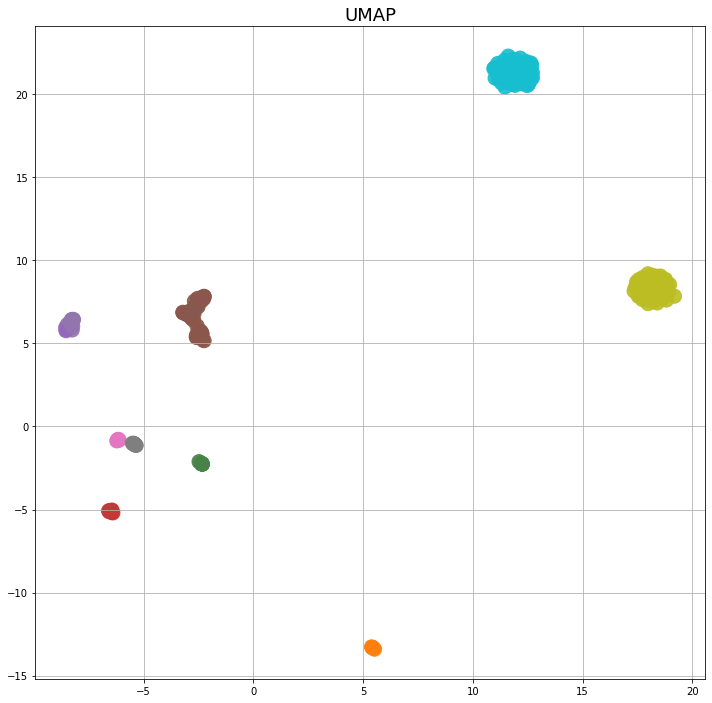

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.scatter(embedding[:, 0], embedding[:, 1], c=cluster_colors, s=200, alpha=0.9)
ax.grid(True)
ax.set_title("UMAP", fontsize=18);

In [30]:
df_umap = pd.DataFrame({
    'x': embedding[:, 0],
    'y': embedding[:, 1],
    'label': df.labels,
    'text': df.text
})

Note that only the 1st and 2nd columns of the UMAP dataframe will be different from the TSNE dataframe, since we are taking the label data and text data from the HDB Scan algorithm that was done earlier.

### 4.4 K-Means

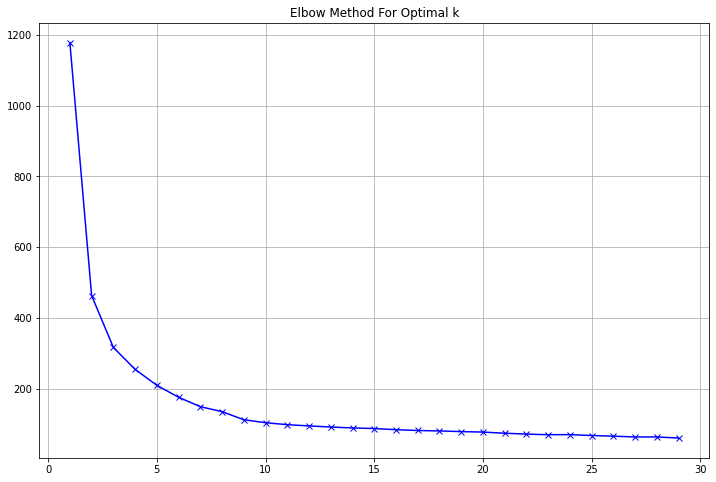

In [42]:
from sklearn.cluster import KMeans

fig, ax = plt.subplots(1, 1, figsize=(12, 8))
Sum_of_squared_distances = []
K = range(1,30)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(df_vecs.T)
    Sum_of_squared_distances.append(km.inertia_)
ax.plot(K, Sum_of_squared_distances, 'bx-')
ax.set_title('Elbow Method For Optimal k')
ax.grid(True)

In [61]:
df['kmeans-label'] = label

In [63]:
df['kmeans-label'].value_counts()

0    212
3     35
2     20
1     15
5     10
8      9
4      9
7      6
6      6
Name: kmeans-label, dtype: int64

In [68]:
for i in [0, 3, 2, 1]:
    df[df['kmeans-label']==i].to_excel(f'kmeans-label{i}.xlsx')

In [70]:
for lbl in [0, 3, 2, 1]:
    files.download(f'kmeans-label{lbl}.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

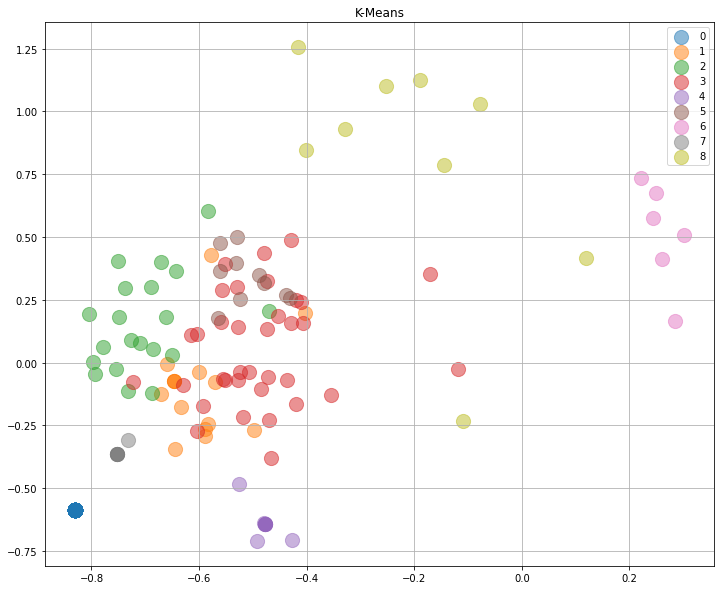

In [48]:
kmeans = KMeans(n_clusters=9)  # Previously 15
label = kmeans.fit_predict(df_vecs.T)
u_labels = np.unique(label)

fig, ax = plt.subplots(1, 1, figsize=(12, 10))
for i in u_labels:
    ax.scatter(df_vecs.T[label == i, 0],
               df_vecs.T[label == i, 1],
               label = i, s = 200, alpha=0.5)
ax.legend()
ax.grid(True)
ax.set_title('K-Means');

### 4.5 HDBScan

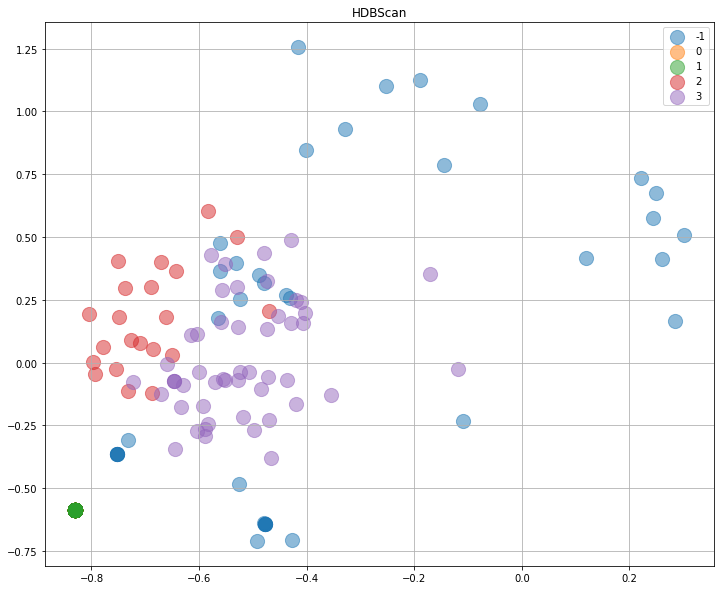

In [45]:
clusterhdb = hdbscan.HDBSCAN(min_cluster_size=15)
label = clusterhdb.fit_predict(df_vecs.T)

u_labels = np.unique(label)
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
for i in u_labels:
    ax.scatter(df_vecs.T[label == i, 0],
               df_vecs.T[label == i , 1],
               label = i, s = 200, alpha = 0.5)
ax.legend()
ax.grid(True)
ax.set_title('HDBScan');